In [1]:
!date
!pwd

Вт дек 19 19:06:06 MSK 2017
/home/sphere/github/Sphere/Data2013


In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
#from tqdm import tqdm
#import math as mt
import numpy as np
import seaborn as sns

In [105]:
!ls ./data

10675.txt	flight1.dbg.2013.dat  flight3.dbg.dat
10675.txt.old	flight1.dbg.dat       flight4.dbg.2013.dat
10675.work.txt	flight2.dbg.2013.dat  flight4.dbg.dat
11588.dat	flight2.dbg.dat       flight5.dbg.2013.dat
datum_2013.csv	flight3.dbg.2013.dat  flight5.dbg.dat


In [2]:
datum = pd.read_csv('./data/11588.dat', header = None, index_col=False, sep=',')

In [3]:
datum.head()

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,...,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
1,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,...,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,...,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,...,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0


In [51]:
np.max(np.max(datum))

168.63

In [52]:
np.min(np.min(datum))

-3.0299999999999998

In [3]:
# считать данные, заменив 0 
na_values = ['NO CLUE', 'N/A', '0']
datum11588 = pd.read_csv('./data/11588.work.csv', na_values=na_values, header = None, index_col=False, sep=',')
datum11589 = pd.read_csv('./data/11589.work.csv', na_values=na_values, header = None, index_col=False, sep=',')
datum11308 = pd.read_csv('./data/11308.work.csv', na_values=na_values, header = None, index_col=False, sep=',')
datum11452 = pd.read_csv('./data/11452.work.csv', na_values=na_values, header = None, index_col=False, sep=',')
datum12114 = pd.read_csv('./data/12114.work.csv', na_values=na_values, header = None, index_col=False, sep=',')

In [9]:
datum11468 = pd.read_csv('./data/11468.work.csv', header = None, index_col=False, sep=',')
datum11302 = pd.read_csv('./data/11302.work.csv', header = None, index_col=False, sep=',')

In [4]:
# убрать последние три канала
param = [i for i in range(109)]

datum11588 = datum11588[param]
datum11589 = datum11589[param]
datum11308 = datum11308[param]
datum11452 = datum11452[param]
datum12114 = datum12114[param]

In [5]:
datum11588.shape

(970, 109)

In [6]:
datum11589.tail(2)

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# отрицательные значения заменить на маленькое положительное
minpos = 0.0001
data = [datum11588, datum11589,datum11308, datum11452, datum12114]
for datum in data:
    for i in range(datum.shape[1]):
        zero_cell = datum[i] <= 3
        datum.loc[zero_cell, i] = minpos
    datum.fillna(0.001, inplace = True)

In [8]:
datum11589.tail(2)

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
968,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
969,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001


In [9]:
plt.rcParams['figure.figsize'] =(8,4)
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 14

'\nif colorscale == "gist_yarg":\n    plt.savefig(\'frames_bw.pdf\', bbox_inches=\'tight\')\nelse:    \n    plt.savefig(\'frames_col_bugn.pdf\', bbox_inches=\'tight\')\n    #plt.savefig(\'frames_col.eps\', bbox_inches=\'tight\')\n'

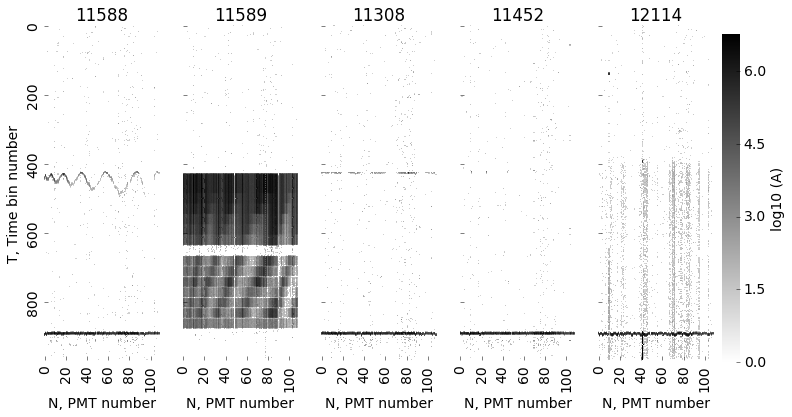

In [10]:
colorscale = "gist_yarg"
#colorscale = "BuGn" #cool"
#colorscale='PuBuGn' #"gist_yarg" #'BuPu' #  'GnBu'   #'viridis' #'Greys'
data = [datum11588, datum11589,datum11308, datum11452, datum12114]
title = ['11588', '11589','11308','11452', '12114']
fig = plt.figure(figsize=(12,6))

fig, axn = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(12,6))
cbar_ax = fig.add_axes([.91, .12, .02, .76])
cbar_kws = {"label":'log10 (A)'}
n=150
cbar = False

for (i, ax), datum in zip(enumerate(axn.flat), data):
    n += 1
    sns.heatmap(np.log(datum), ax=ax, cmap = colorscale,
                cbar=i == 0,
                vmin=0, 
                xticklabels=20, yticklabels=200,
                cbar_ax=None if i else cbar_ax,
                cbar_kws = None if i else cbar_kws,
               )
    ax.set_title(title[n-151])
    ax.set_xlabel('N, PMT number')
    if n == 151:
        ax.set_ylabel('T, Time bin number')

'''
if colorscale == "gist_yarg":
    plt.savefig('frames_bw.pdf', bbox_inches='tight')
else:    
    plt.savefig('frames_col_bugn.pdf', bbox_inches='tight')
    #plt.savefig('frames_col.eps', bbox_inches='tight')
'''

C:\Program Files\Anaconda\lib\site-packages\matplotlib\gridspec.py:302: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


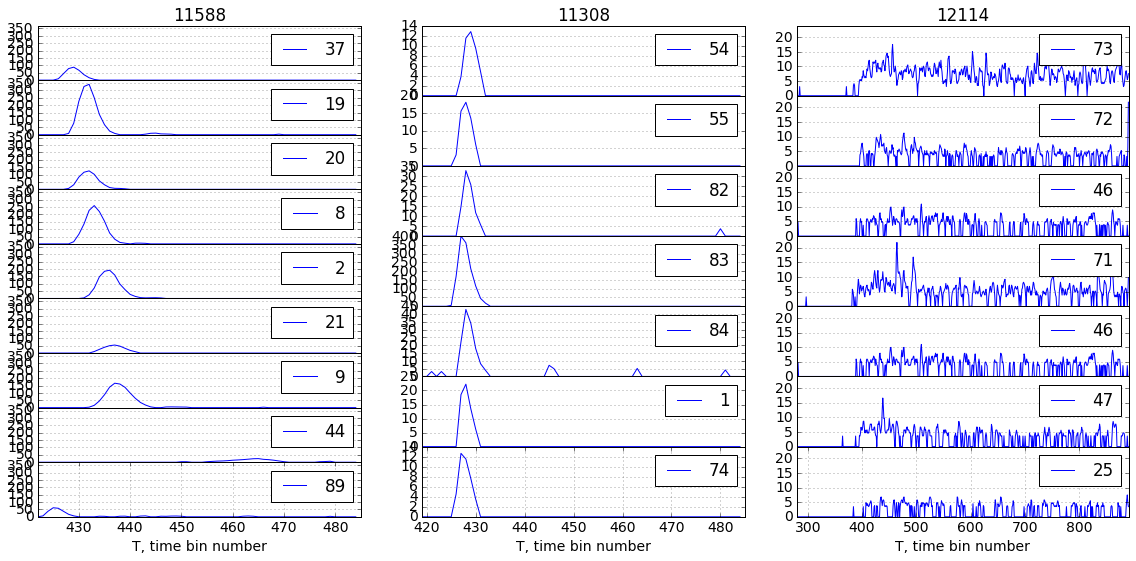

In [14]:
fig = plt.figure(figsize=(16,8))

frame = [datum11588, datum11589, datum11308, datum11452, datum12114]
title = ['11588', '11589','11308','11452', '12114']
frame = [datum11588, datum11308,  datum12114]
title = ['11588', '11308', '12114']
data = [[36, 18, 19,  7,  1, 20,  8, 43, 88], # 11588
        [53, 54, 81, 82, 83,  0, 73],         # 11308
        [72, 71, 45, 70, 45, 46, 24]]         # 12114
axmin = [422, 419, 280]
axmax = [485, 485, 891] 
aylim = [(0,370), (0), (0,24)]
gs = []
dd = len(frame)
#gs = [gridspec.GridSpec(len(data[num]), 1) for num in range(dd)]

######### plot frames #################
num = 0
for num in range(dd):
    gscur = gridspec.GridSpec(len(data[num]), 1)

    xmin = axmin[num]
    xmax = axmax[num]
    for i, n in enumerate(data[num]):
        ax = fig.add_subplot(gscur[i])
        ax.plot(frame[num][n][xmin:xmax], label = str(n+1))
        ax.axes.get_xaxis().set_visible(False)
        if i == 0:
            ax.set_title(title[num])
        plt.ylim(aylim[num])
        plt.xlim(xmin,xmax)
        plt.legend()
        plt.grid()
    ax.axes.get_xaxis().set_visible(True)
    ax.set_xlabel('T, time bin number')

    # tight_layout
    gscur.tight_layout(fig, rect=[num/dd, 0, (num+1)/dd, 1], h_pad = 0.5)
    gs.append(gscur)

########################
top    = min(x.top    for x in gs)
bottom = max(x.bottom for x in gs)
for gscur in gs:
    gscur.update(top=top, bottom=bottom, hspace = 0.0)

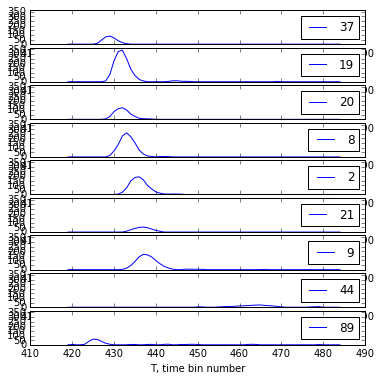

In [21]:
data = [1, 2, 8, 7, 6, 17, 18]
data = [17, 18, 7, 6, 1, 8, 2]
data = [36, 18, 19,7,  1, 20, 8, 43, 88]

fig = plt.figure(figsize=(6,6))

n = len(data) * 100 + 10
xmin = 419 #390
xmax = 485 #70
for i in data:
    n += 1
    ax = fig.add_subplot(n)
    plt.plot(datum11588[i][xmin:xmax], label = str(i+1))
    plt.ylim(0,370)
    plt.legend()
    #plt.grid()
    
plt.xlabel('T, time bin number')
fig.subplots_adjust(hspace = 0.1)

plt.savefig('event_channels.eps', bbox_inches='tight')

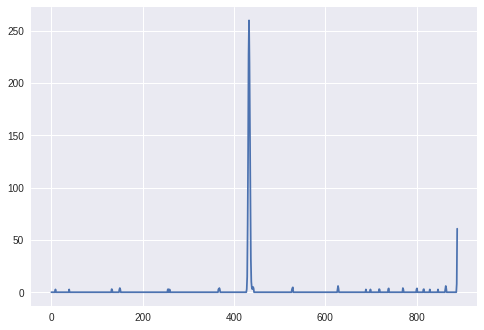

In [469]:
plt.plot(datum11588[7][:890])

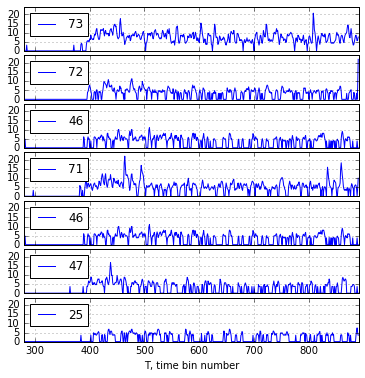

In [22]:
data = [72, 71, 45,70,  45, 46, 24]

fig = plt.figure(figsize=(6,6))

n=710
ymax = 891
for i in data:
    n += 1
    ax = fig.add_subplot(n)
    plt.plot(datum12114[i][280:ymax]+0.1, label = str(i+1))
    plt.ylim(0)
    plt.xlim(280,ymax)
    plt.ylim(0,24)
    plt.legend(loc = 2) 
    plt.grid()
    
plt.xlabel('T, time bin number')
fig.subplots_adjust(hspace = 0.1)

plt.savefig('door_channels.eps', bbox_inches='tight')

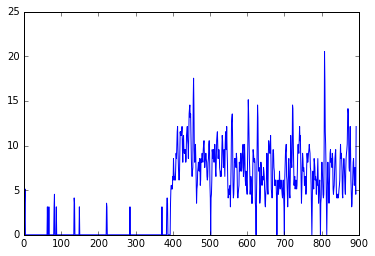

In [23]:
plt.plot(datum12114[72][:894])

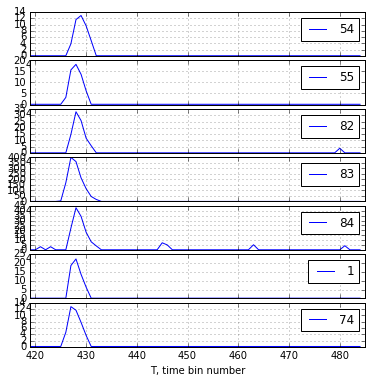

In [24]:
data = [72, 71, 45,70,  45, 46, 24]
data = [53, 54, 81, 82, 83, 0, 73]

fig = plt.figure(figsize=(6,6))

n=710
xmin = 419 #390
xmax = 448 #70
xmin = 419 #390
xmax = 485 #70

for i in data:
    n += 1
    ax = fig.add_subplot(n)
    plt.plot(datum11308[i][xmin:xmax]+0.1, label = str(i+1))
    plt.ylim(0)
    plt.xlim(xmin,xmax)
    plt.legend(loc = 1)
    plt.grid()
    
plt.xlabel('T, time bin number')
fig.subplots_adjust(hspace = 0.1)

plt.savefig('line_channels.eps', bbox_inches='tight')

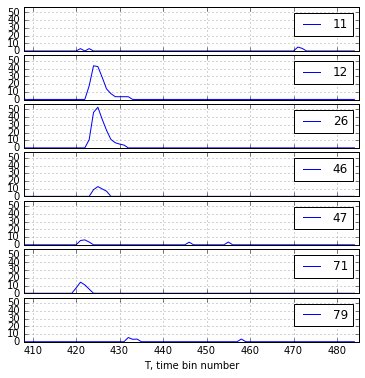

In [25]:
data = [10, 11, 25, 45, 46, 70, 78]

fig = plt.figure(figsize=(6,6))

n=710
xmin = 408 #390
xmax = 485 #70

for i in data:
    n += 1
    ax = fig.add_subplot(n)
    plt.plot(datum11452[i][xmin:xmax]+0.1, label = str(i+1))
    plt.ylim(0)
    plt.xlim(xmin,xmax)
    plt.ylim(0,57)
    plt.legend(loc = 1) 
    plt.grid()
    
plt.xlabel('T, time bin number')
fig.subplots_adjust(hspace = 0.1)

plt.savefig('noise_channels.eps', bbox_inches='tight')

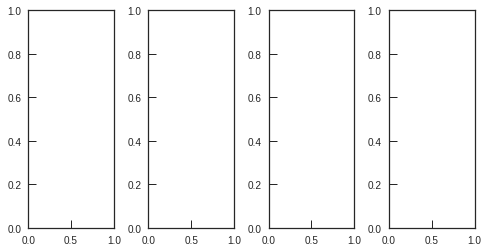

In [857]:
grid = plt.GridSpec(7, 4, wspace=0.4, hspace=0.3)
plt.subplot(grid[:, 0])
plt.subplot(grid[:, 1])
plt.subplot(grid[:, 2])
plt.subplot(grid[:, 3]);

C:\Program Files\Anaconda\lib\site-packages\matplotlib\gridspec.py:302: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


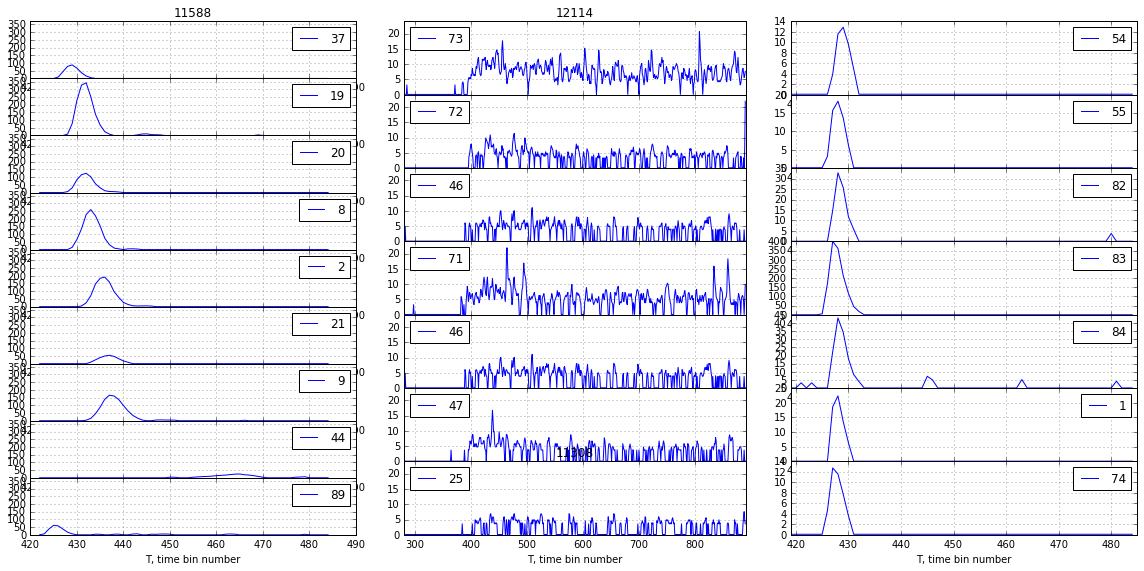

In [68]:
fig = plt.figure(figsize=(16,8))

frame = [datum11588, datum11589, datum11308, datum11452, datum12114]
title = ['11588', '11589','11308','11452', '12114']

######### event #################
data = [36, 18, 19, 7, 1, 20, 8, 43, 88]
n = len(data)
gs1 = gridspec.GridSpec(n, 1)

xmin = 422 #390
xmax = 485 #70
i = -1
for n in data:
    i += 1
    ax = fig.add_subplot(gs1[i])
    ax.plot(frame[0][n][xmin:xmax], label = str(n+1))
    if i == 0:
        ax.set_title(title[0])
    plt.ylim(0,370)
    plt.legend()
    plt.grid()
    
plt.xlabel('T, time bin number')
gs1.tight_layout(fig, rect=[0, 0, 0.33, 1])

########## door ############
data = [72, 71, 45,70,  45, 46, 24]
gs2 = gridspec.GridSpec(len(data), 1)

i=-1
ymax = 891
for n in data:
    i += 1
    bx = fig.add_subplot(gs2[i])
    bx.plot(datum12114[n][280:ymax]+0.1, label = str(n+1))
    if i == 0:
        bx.set_title(title[4])
    plt.xlim(280,ymax)
    plt.ylim(0,24)
    plt.legend(loc = 2) 
    plt.grid()
    
bx.set_xlabel('T, time bin number')
gs2.tight_layout(fig, rect=[0.33, 0, 0.66, 1], h_pad=0.5)

######### line #############
data = [53, 54, 81, 82, 83, 0, 73]
gs3 = gridspec.GridSpec(len(data), 1)

xmin = 419 #390
xmax = 485 #70
i = -1
for n in data:
    i += 1
    cx = fig.add_subplot(gs3[i])
    cx.plot(datum11308[n][xmin:xmax]+0.1, label = str(n+1))
    if i == 0:
        bx.set_title(title[2])
    plt.ylim(0)
    plt.xlim(xmin,xmax)
    plt.legend(loc = 1)
    plt.grid()
    
cx.set_xlabel('T, time bin number')
gs3.tight_layout(fig, rect=[0.66, 0, 1, 1], h_pad=0.5)

########################
top    = min(gs1.top, gs2.top, gs3.top)
bottom = max(gs1.bottom, gs2.bottom, gs3.bottom)
gs1.update(top=top, bottom=bottom, hspace = 0.0)
gs2.update(top=top, bottom=bottom, hspace = 0.0)
gs3.update(top=top, bottom=bottom, hspace = 0.0)
